# Which Economic Tasks are Performed with AI? Evidence from Millions of Claude Conversations

_Handa et al., 2025_

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import numpy as np
import os

palette = sns.color_palette("colorblind")

## Frequency Weighted Percents

In [ ]:

df = pd.read_csv("../data/tasks_final.csv")
years_ratings = [2015, 2025]
years_wage_emp = [2015, 2024]

# Create freq adjusted mean
for year in years_ratings:
    df[f"pct_freq_adj_{year}"] = ((df["pct_normalized"]/df[f"freq_mean_{year}"]) / (df["pct_normalized"]/df[f"freq_mean_{year}"]).sum()) * 100
    print(df[f"pct_freq_adj_{year}"].sum())

# Create task x emp pct
for year in years_wage_emp:
    df[f"task_freq_pct_{year}"] = ((df["pct_normalized"]/df[f"freq_mean_{year}"]) / (df["pct_normalized"]/df[f"freq_mean_{year}"]).sum()) * 100

100.0
100.0


In [ ]:
outdir = "../charts/top_tasks"
os.makedirs(outdir, exist_ok=True)

pcts = ["pct_normalized", "pct_freq_adj"]
task_types = ["All", "Core", "Supplemental"]
geos = ["nat", "utah"]
years = [2015, 2024]
top_n = 20

for pct_col in pcts:
    for ttype in task_types:
        for geo in geos:
            for yr in years:
                # --- 1) subset by task type ---
                if ttype == "All":
                    subset = df.copy()
                else:
                    subset = df[df["task_type"] == ttype]

                # --- 2) employment * task share ---
                emp_col = f"emp_tot_{geo}_{yr}"
                if emp_col not in subset.columns:
                    continue  # skip if column missing

                # scale contribution of each task
                subset["task_emp_share"] = subset[pct_col] * subset[emp_col]

                # --- 3) aggregate to task level ---
                agg = (subset.groupby("task")["task_emp_share"]
                             .sum()
                             .sort_values(ascending=False)
                             .head(top_n)
                             .reset_index())

                # --- 4) plotting ---
                plt.figure(figsize=(12, 8))
                sns.barplot(data=agg, x="task_emp_share", y="task", color="skyblue")

                # wrap y labels
                ax = plt.gca()
                ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40))
                                    for label in ax.get_yticklabels()])

                plt.title(f"Top {top_n} Tasks | {pct_col} | {ttype} | {geo.upper()} | {yr}")
                plt.xlabel("Employment-weighted Task Share")
                plt.ylabel("Task")

                plt.tight_layout()

                # --- 5) save ---
                fname = f"top{top_n}_tasks_{pct_col}_{ttype}_{geo}_{yr}.png"
                plt.savefig(os.path.join(outdir, fname))
                plt.close()


In [14]:
# Core and suppl make up

def core_suppl_makeup(df):
    # Sum normalized percent for Core tasks
    core_sum = df[df["task_type"] == "Core"]["pct_occ_norm"].sum()

    # Sum normalized percent for Supplemental tasks
    supp_sum = df[df["task_type"] == "Supplemental"]["pct_occ_norm"].sum()


    # Get unique tasks for each type
    core_tasks = df[df["task_type"] == "Core"]["task"].unique()
    suppl_tasks = df[df["task_type"] == "Supplemental"]["task"].unique()
    empty_tasks = df[df["task_type"].isna()]["task"].unique()

    # Convert to sets to avoid duplicates
    core_set = set(core_tasks)
    suppl_set = set(suppl_tasks)
    empty_set = set(empty_tasks)

    # Union of all unique tasks
    all_unique_tasks = core_set.union(suppl_set).union(empty_set)
    total_unique = len(all_unique_tasks)

    # Compute and print percentages
    core_pct = len(core_set) / total_unique * 100
    suppl_pct = len(suppl_set) / total_unique * 100
    empty_pct = len(empty_set) / total_unique * 100

    print(f"Total Unique Tasks: {total_unique}")
    print(f"Core (%): {core_pct:.2f}%")
    print(f"Supplemental (%): {suppl_pct:.2f}%")
    print(f"Empty/Unlabeled (%): {empty_pct:.2f}%")

    print(f"Core Tasks Total %: {core_sum:.2f}")
    print(f"Supplemental Tasks Total %: {supp_sum:.2f}")

core_suppl_makeup(base_df)

Total Unique Tasks: 3515
Core (%): 78.83%
Supplemental (%): 18.26%
Empty/Unlabeled (%): 3.56%
Core Tasks Total %: 84.93
Supplemental Tasks Total %: 12.40


## EXPERIMENTS

### TASKS

In [ ]:

# # NEW Font Sizes

plt.rcParams['font.size'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 24

sns.set_context("notebook", font_scale=1.7)

In [39]:
i = 0
cell_chart_name = "Top Tasks by % of Conversations"
output_dir = f"../charts/{cell_chart_name}"
os.makedirs(output_dir, exist_ok=True)

for df in dfs_list:
    for col in columns_list:
        # Get top 10 tasks overall to ensure consistent comparison
        total_tasks = (df.groupby("Task")[col]
            .sum()
            .sort_values(ascending=False))
        top_10_tasks = total_tasks.head(10).index

        # Create plot dataframe with all groups
        plot_df = (df[df["Task"].isin(top_10_tasks)]
            .groupby(["Task"])[col]
            .sum()
            .reset_index())

        # Sort tasks by overall frequency - REDUNDANT CODE CHANGE
        task_order = plot_df.sort_values(by=col, ascending=False)["Task"]
        plot_df["Task"] = pd.Categorical(plot_df["Task"], categories=task_order, ordered=True)

        # Create the plot
        num_tasks = len(top_10_tasks)
        height_per_task = 1.6  # tweak as needed
        fig_height = num_tasks * height_per_task
        plt.figure(figsize=(16, fig_height))
        sns.barplot(
            data=plot_df,
            x=col,
            y="Task",
            color=palette[0],
        )

        # Wrap task titles
        ax = plt.gca()
        ticks = ax.get_yticks()
        ax.set_yticks(ticks)
        ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40)) 
                            for label in ax.get_yticklabels()])

        # Modify legend
        handles, labels = ax.get_legend_handles_labels()
        
        # Wrap task labels
        ax = plt.gca()
        ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40)) 
                            for label in ax.get_yticklabels()])
        
        # Format x-axis as percentages
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
        
        # Customize the plot
        plt.title(f"{names_list[i]} {cell_chart_name}")
        plt.xlabel('Percentage of Records')
        plt.ylabel('O*NET Task')

        # Adjust layout to prevent label cutoff
        plt.tight_layout()

        title = ax.get_title()
        title_clean = title.lower().replace('%', 'percent').replace(' ', '_').replace('/', '_')
        plt.savefig(f"{output_dir}/{title_clean}.png", dpi=300, bbox_inches='tight')
        i = i+1

        plt.close()

### OCCUPATIONS

In [40]:
grouped_with_occupations_all.groupby("Title")["pct_occ_norm"].sum()

Title
Accountants                           0.401014
Actors                                0.784222
Actuaries                             0.064806
Acupuncturists                        0.028148
Acute Care Nurses                     0.040062
                                        ...   
Wind Energy Engineers                 0.002880
Wind Energy Operations Managers       0.008903
Wind Energy Project Managers          0.014794
Word Processors and Typists           0.415677
Zoologists and Wildlife Biologists    0.039800
Name: pct_occ_norm, Length: 756, dtype: float64

In [41]:
i = 0
cell_chart_name = "Top Occupations by % of Conversations"
output_dir = f"../charts/{cell_chart_name}"
os.makedirs(output_dir, exist_ok=True)

for df in dfs_list:
    for col in columns_list:

        # Calculate percentages per group and occupation
        plot_df = (df.groupby("Title")[col]
                   .sum()
                   .reset_index())
        
        # Get top occupations overall
        total_occs = (plot_df.groupby("Title")[col]
                      .sum()
                      .sort_values(ascending=False))
        top_occs = total_occs.head(15).index
        
        # Filter for top occupations
        plot_df = plot_df[plot_df["Title"].isin(top_occs)]
        
        # Sort occupations by overall frequency
        occ_order = (plot_df.groupby("Title")[col]
                     .sum()
                     .sort_values(ascending=False)
                     .index)
        plot_df["Title"] = pd.Categorical(plot_df["Title"], categories=occ_order, ordered=True)
        
        # Create the plot
        plt.figure(figsize=(18, 16))
        sns.barplot(
            data=plot_df,
            x=col,
            y="Title",
            color=palette[0],
        )
        
        # Wrap occupation titles
        ax = plt.gca()
        ticks = ax.get_yticks()
        ax.set_yticks(ticks)
        ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40)) 
                            for label in ax.get_yticklabels()])
        
        # Format x-axis as percentages
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
        
        # Customize the plot
        plt.title(f"{names_list[i]} {cell_chart_name}")
        plt.xlabel('Percentage of Conversations')
        plt.ylabel('Occupation')
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        title = ax.get_title()
        title_clean = title.lower().replace('%', 'percent').replace(' ', '_').replace('/', '_')
        plt.savefig(f"{output_dir}/{title_clean}.png", dpi=300, bbox_inches='tight')
        i = i+1

        plt.close()

### OCCUPATIONAL CATEGORIES

In [42]:
i = 0
cell_chart_name = "Occupational Categories by % of Conversations"
output_dir = f"../charts/{cell_chart_name}"
os.makedirs(output_dir, exist_ok=True)

for df in dfs_list:
    for col in columns_list:
        
        # Calculate percentages per group and occupational category
        plot_df = (df.groupby("SOC or O*NET-SOC 2019 Title")[col]
                   .sum()
                   .reset_index())
        
        # Sort categories by group-1 frequency
        cat_order = plot_df.sort_values(col, ascending=False)["SOC or O*NET-SOC 2019 Title"]
        plot_df["SOC or O*NET-SOC 2019 Title"] = pd.Categorical(
            plot_df["SOC or O*NET-SOC 2019 Title"], 
            categories=cat_order, 
            ordered=True
        )
        
        # Create the plot
        plt.figure(figsize=(18, 16))
        sns.barplot(
            data=plot_df,
            x=col,
            y="SOC or O*NET-SOC 2019 Title",
            color=palette[0],
        )
        
        # Wrap category labels and remove " Occupations" string
        ax = plt.gca()
        ticks = ax.get_yticks()
        ax.set_yticks(ticks)
        ax.set_yticklabels(['\n'.join(wrap(label.get_text().replace(" Occupations", ""), width=60)) 
                            for label in ax.get_yticklabels()])
        
        # Format x-axis as percentages
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
        
        # Customize the plot
        plt.title(f"{names_list[i]} {cell_chart_name}")
        plt.xlabel('Percentage of Conversations')
        plt.ylabel('Occupational Category')
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        title = ax.get_title()
        title_clean = title.lower().replace('%', 'percent').replace(' ', '_').replace('/', '_')
        plt.savefig(f"{output_dir}/{title_clean}.png", dpi=300, bbox_inches='tight')
        i = i+1

        plt.close()

In [43]:
grouped_with_occupations_all

,task_name,pct,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,soc_major_group,SOC or O*NET-SOC 2019 Title,task_normalized,n_occurrences,n_occurrences_soc,pct_occ_weighted,pct_occ_norm
0,act as advisers to student organizations.,0.006775,25-1011.00,"Business Teachers, Postsecondary",5682.0,Act as advisers to student organizations.,Core,95.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,1.0,0.005572,0.000200
1,act as advisers to student organizations.,0.006775,25-1021.00,"Computer Science Teachers, Postsecondary",5700.0,Act as advisers to student organizations.,Supplemental,58.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,1.0,0.005572,0.000200
2,act as advisers to student organizations.,0.006775,25-1022.00,"Mathematical Science Teachers, Postsecondary",5726.0,Act as advisers to student organizations.,Supplemental,107.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,1.0,0.005572,0.000200
3,act as advisers to student organizations.,0.006775,25-1031.00,"Architecture Teachers, Postsecondary",5751.0,Act as advisers to student organizations.,Supplemental,72.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,1.0,0.005572,0.000200
4,act as advisers to student organizations.,0.006775,25-1032.00,"Engineering Teachers, Postsecondary",5774.0,Act as advisers to student organizations.,Supplemental,70.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,1.0,0.005572,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,"write, design, or edit web page content, or di...",0.320908,15-1134.00,Web Developers,14696.0,"Write, design, or edit Web page content, or di...",Core,30.0,06/2008,Occupational Expert,15,Computer and Mathematical Occupations,"write, design, or edit web page content, or di...",1.0,1.0,0.263920,0.322461
4241,"write, present, and publish reports that recor...",0.117393,19-3091.02,Archeologists,9155.0,"Write, present, and publish reports that recor...",Core,33.0,07/2012,Occupational Expert,19,"Life, Physical, and Social Science Occupations","write, present, and publish reports that recor...",1.0,1.0,0.096545,0.117961
4242,"write, review, or execute plans for testing ne...",0.010944,15-1199.12,Document Management Specialists,16220.0,"Write, review, or execute plans for testing ne...",Core,25.0,07/2013,Occupational Expert,15,Computer and Mathematical Occupations,"write, review, or execute plans for testing ne...",1.0,1.0,0.009001,0.010997
4243,"write, review, or maintain engineering documen...",0.076872,17-2141.02,Automotive Engineers,16425.0,"Write, review, or maintain engineering documen...",Core,23.0,07/2014,Occupational Expert,17,Architecture and Engineering Occupations,"write, review, or maintain engineering documen...",1.0,1.0,0.063221,0.077244


In [44]:
# Load employment data
bls_employment_df = pd.read_csv("../original_data/bls_employment_may_2023.csv")

# claude_employment_df = grouped_with_occupations_all.groupby("SOC or O*NET-SOC 2019 Title")["pct_occ_norm"].sum().reset_index(name='claude_distribution')

# employment_df = claude_employment_df.merge(bls_employment_df, 
#                                      on='SOC or O*NET-SOC 2019 Title',
#                                      how='left')

In [45]:
# Calculate percentages and setup data
def get_distribution(df, value_column):
   total = df[value_column].sum()
   return (df[value_column] / total * 100).round(1)


j = 0
cell_chart_name = "Percent Soc Vs Covo"
output_dir = f"../charts/{cell_chart_name}"
os.makedirs(output_dir, exist_ok=True)
    
for df in dfs_list:
    for col in columns_list:

        
        claude_employment_df = df.groupby("SOC or O*NET-SOC 2019 Title")[col].sum().reset_index(name='claude_distribution')
        
        employment_df = claude_employment_df.merge(bls_employment_df, 
                                             on='SOC or O*NET-SOC 2019 Title',
                                             how='left')
        plot_df = employment_df.copy()

        plot_df['bls_pct'] = get_distribution(plot_df, 'bls_distribution')
        plot_df['claude_pct'] = get_distribution(plot_df, 'claude_distribution')
        plot_df['clean_label'] = plot_df['SOC or O*NET-SOC 2019 Title'].str.replace(' Occupations', '')
        plot_df['pct_difference'] = plot_df['claude_pct'] - plot_df['bls_pct']
        plot_df = plot_df.sort_values('bls_pct', ascending=True)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(20, 12))
        
        # Set colors
        claude_color = palette[1] 
        bls_color = palette[0] 
        
        # Create lines and circles
        y_positions = range(len(plot_df))
        for i, row in enumerate(plot_df.itertuples()):
           # Determine color based on which value is larger
           line_color = claude_color if row.claude_pct > row.bls_pct else bls_color
           
           # Draw the line between bls and claude percentages
           ax.plot([row.bls_pct, row.claude_pct], [i, i], 
                   color=line_color, 
                   linestyle='-', 
                   linewidth=2.5,
                   zorder=1)
           
           # Determine label positioning
           if row.claude_pct > row.bls_pct:
               bls_ha = 'right'
               claude_ha = 'left'
               bls_offset = -0.4
               claude_offset = 0.4
           else:
               bls_ha = 'left'
               claude_ha = 'right'
               bls_offset = 0.4
               claude_offset = -0.4
        
           # Plot BLS percentage
           ax.scatter([row.bls_pct], [i], 
                      color=bls_color,
                      s=200,
                      zorder=2,
                      label='% of U.S. workers (BLS)' if i == 0 else "")
           ax.text(row.bls_pct + bls_offset,
                   i,
                   f'{row.bls_pct:.1f}%',
                   ha=bls_ha,
                   va='center',
                   color=bls_color)
           
           # Plot Claude's percentage
           ax.scatter([row.claude_pct], [i], 
                      color=claude_color,
                      s=200,
                      zorder=2,
                      label=f"% of Claude conversations {names_list[i]}" if i == 0 else "")
           ax.text(row.claude_pct + claude_offset,
                   i,
                   f'{row.claude_pct:.1f}%',
                   ha=claude_ha,
                   va='center',
                   color=claude_color)
        
        # Customize the plot
        ax.set_xlabel('Percentage')
        ax.set_ylabel('Occupational Category')
        
        # Add percentage formatter to x-axis
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
        
        # Set y-axis labels
        ax.set_yticks(y_positions)
        ax.set_yticklabels(plot_df['clean_label'])
        
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[::-1]
        labels = labels[::-1]
        ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 0.0))
        
        # Adjust grid and layout
        ax.grid(axis='x', linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)
        
        # Set axis limits with padding
        max_val = max(plot_df['bls_pct'].max(), plot_df['claude_pct'].max())
        min_val = min(plot_df['bls_pct'].min(), plot_df['claude_pct'].min())
        padding = (max_val - min_val) * 0.15
        ax.set_xlim(min_val - padding, max_val + padding)
        ax.set_ylim(-1, len(plot_df))
        
        # Adjust layout
        plt.title(f"{names_list[j]} {cell_chart_name}")
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        title = ax.get_title()
        title_clean = title.lower().replace('%', 'percent').replace(' ', '_').replace('/', '_')
        plt.savefig(f"{output_dir}/{title_clean}.png", dpi=300, bbox_inches='tight')
        j = j+1

        plt.close()

### USAGE BY WAGE

In [46]:
# Read and process wage data
wage_df = pd.read_csv("../original_data/wage_data.csv")

In [47]:
wage_df

,SOCcode,JobName,JobFamily,isBright,isGreen,JobZone,MedianSalary,JobForecast,ChanceAuto,WageGroup
0,13-2011.01,Accountants,Business and Financial Operations,True,False,4,70500.00,146000,-1.0,Accountants and Auditors
1,13-2011.00,Accountants and Auditors,Business and Financial Operations,True,False,-1,70500.00,146000,94.0,NaN
2,27-2011.00,Actors,"Arts, Design, Entertainment, Sports, and Media",False,False,2,17.54,7700,37.0,NaN
3,15-2011.00,Actuaries,Computer and Mathematical,True,False,4,102880.00,2200,21.0,NaN
4,29-1199.01,Acupuncturists,Healthcare Practitioners and Technical,True,False,5,73960.00,3400,-1.0,"Health Diagnosing and Treating Practitioners, ..."
...,...,...,...,...,...,...,...,...,...,...
1085,51-7099.00,"Woodworkers, All Other",Production,False,False,-1,31170.00,1900,-1.0,NaN
1086,51-7042.00,"Woodworking Machine Setters, Operators, and Te...",Production,False,False,2,29730.00,11100,97.0,NaN
1087,43-9022.00,Word Processors and Typists,Office and Administrative Support,False,False,2,39750.00,4100,81.0,NaN
1088,27-3043.00,Writers and Authors,"Arts, Design, Entertainment, Sports, and Media",False,False,-1,62170.00,12800,4.0,NaN


In [48]:
# Join wage and occupation data
grouped_with_occupations_and_wage_all = grouped_with_occupations_all.merge(wage_df, left_on="O*NET-SOC Code", right_on="SOCcode", how="left")
grouped_with_occupations_and_wage_all.columns

Index(['task_name', 'pct', 'O*NET-SOC Code', 'Title', 'Task ID', 'Task',
       'Task Type', 'Incumbents Responding', 'Date', 'Domain Source',
       'soc_major_group', 'SOC or O*NET-SOC 2019 Title', 'task_normalized',
       'n_occurrences', 'n_occurrences_soc', 'pct_occ_weighted',
       'pct_occ_norm', 'SOCcode', 'JobName', 'JobFamily', 'isBright',
       'isGreen', 'JobZone', 'MedianSalary', 'JobForecast', 'ChanceAuto',
       'WageGroup'],
      dtype='object')

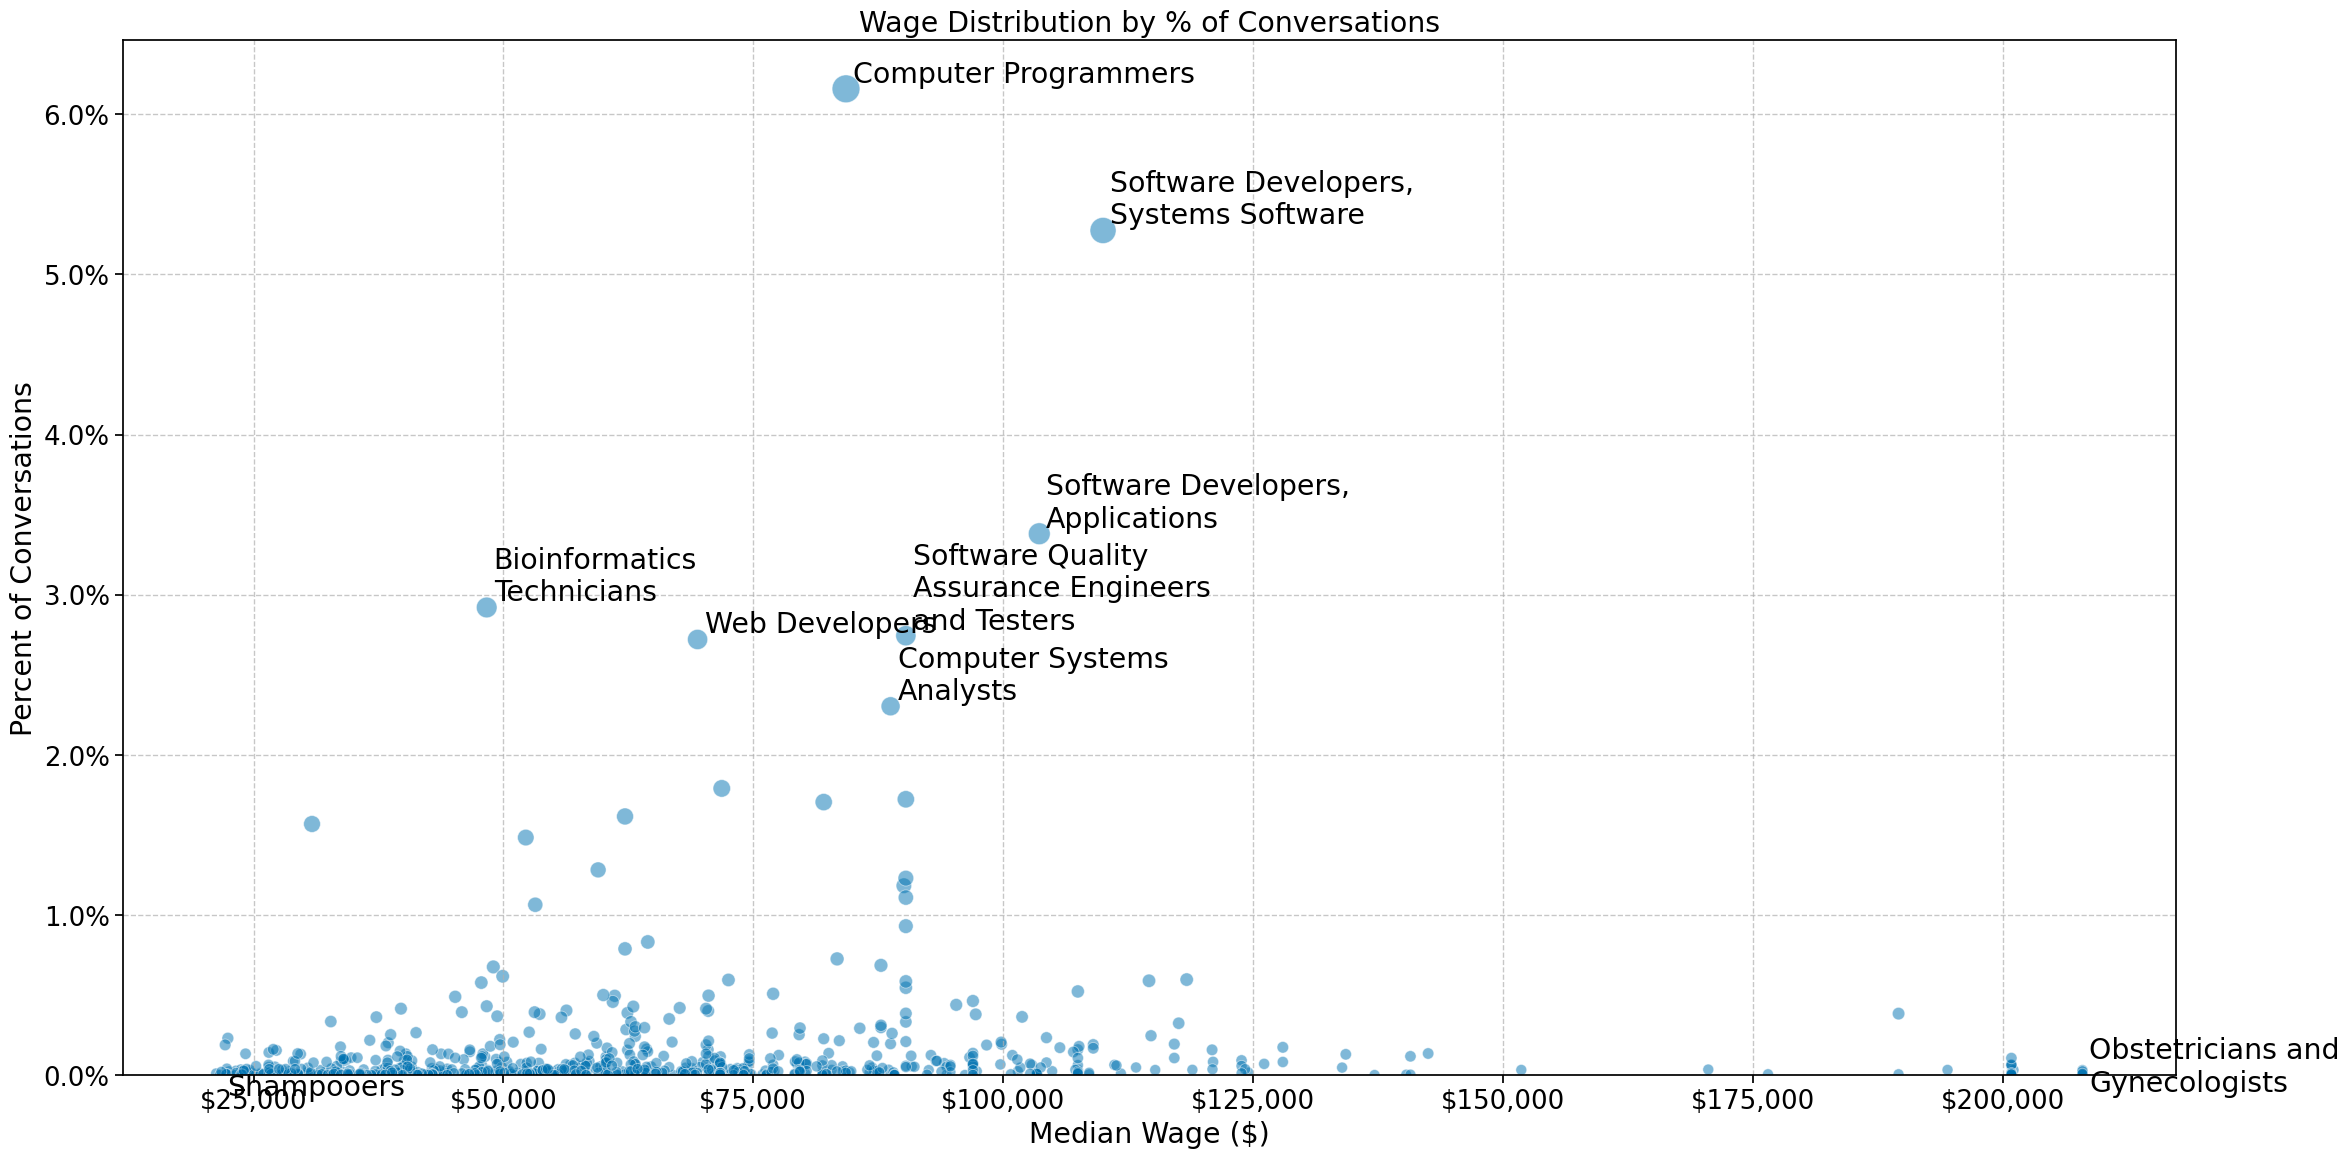

In [49]:
def create_wage_distribution_plot(plot_df):
    # Create figure
    plt.figure(figsize=(24, 12))
    
    # Create scatter plot
    sns.scatterplot(data=plot_df,
                    x='MedianSalary',
                    y='pct_occ_norm',
                    alpha=0.5,
                    size='pct_occ_norm',
                    sizes=(60, 400),
                    color=palette[0],
                    legend=False)
    
    # Style the plot
    plt.xlabel('Median Wage ($)')
    plt.ylabel('Percent of Conversations')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    
    # Add title
    plt.title('Wage Distribution by % of Conversations'), 
    
    # Annotate points
    # Top points by percentage
    top_n = 7
    for _, row in plot_df.nlargest(top_n, 'pct_occ_norm').iterrows():
        plt.annotate('\n'.join(wrap(row['Title'], width=20)), 
                    (row['MedianSalary'], row['pct_occ_norm']),
                    xytext=(5, 5), 
                    textcoords='offset points')
    
    # Extreme salary points
    n_extremes = 2
    # Annotate lowest and highest salaries
    for df_subset in [plot_df.nsmallest(n_extremes, 'MedianSalary'),
                     plot_df.nlargest(n_extremes, 'MedianSalary')]:
        for i, row in enumerate(df_subset.iterrows()):
            if i != 0:  # Skip if already annotated in top_n
                plt.annotate('\n'.join(wrap(row[1]['Title'], width=20)), 
                            (row[1]['MedianSalary'], row[1]['pct_occ_norm']),
                            xytext=(5, -15),
                            textcoords='offset points')
    
    # Formatting
    plt.ylim(bottom=0)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    
    plt.show()
    plt.close()

# Create aggregation dictionary, excluding groupby columns
groupby_cols = ["Title"]
agg_dict = {col: 'first' for col in grouped_with_occupations_and_wage_all.columns 
            if col not in groupby_cols}
agg_dict['pct_occ_norm'] = 'sum'


plot_df = (grouped_with_occupations_and_wage_all
            .groupby(groupby_cols)
            .agg(agg_dict)
            .reset_index()
            .copy())
    
# Filter out null values and very low salaries
plot_df = plot_df[plot_df["MedianSalary"].notnull() & 
                    (plot_df["MedianSalary"] > 100)]
    
# Create and save plot for current group
create_wage_distribution_plot(plot_df)

### AUTOMATION VS AUGMENTATION

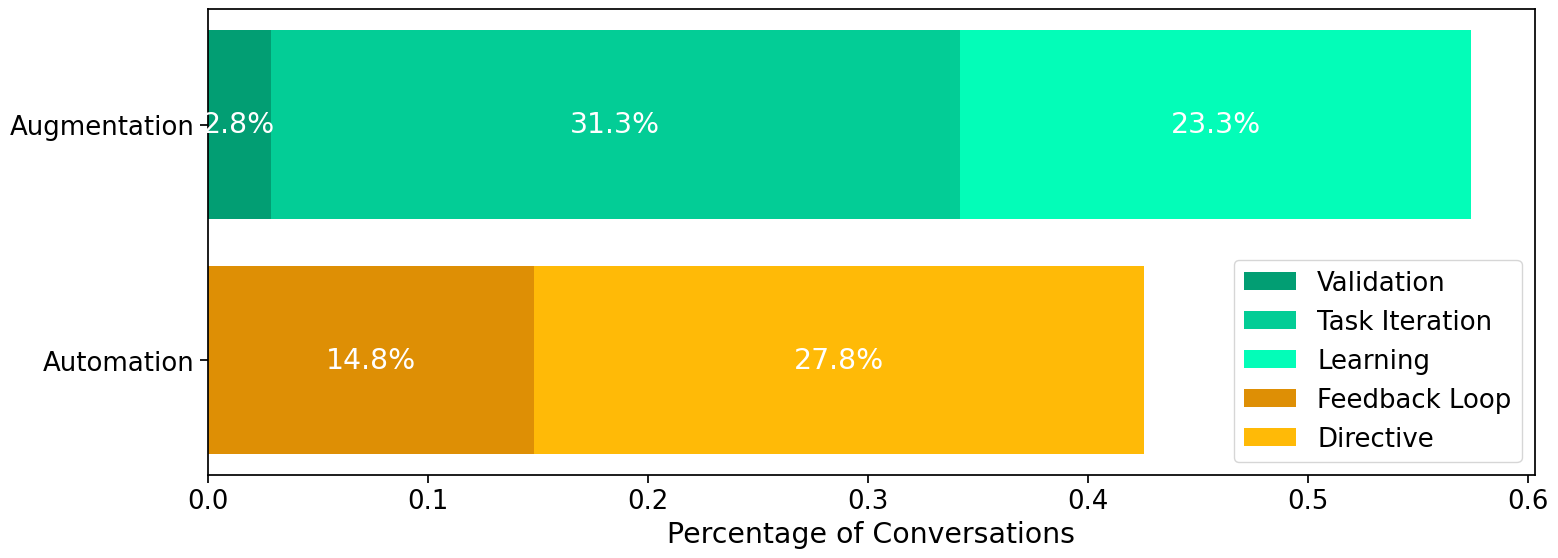

In [50]:
automation_vs_augmentation_df = pd.read_csv("../original_data/automation_vs_augmentation.csv")

def adjust_color_brightness(color, factor):
    """Adjust the brightness of a color by a factor"""
    # Convert color to RGB if it's not already
    if isinstance(color, str):
        color = mcolors.to_rgb(color)
    # Make brighter by scaling RGB values
    return tuple(min(1.0, c * factor) for c in color)

def plot_interaction_modes(df):
    # Load in dataframe
    plot_df = df.copy()
    
    # Convert cluster_name to lowercase first, then filter and normalize
    plot_df['interaction_type'] = plot_df['interaction_type'].str.lower()
    plot_df = plot_df[plot_df['interaction_type'] != 'none']
    total = plot_df['pct'].sum()
    plot_df['pct'] = plot_df['pct'] / total
    
    # Create category mapping
    category_map = {
        'directive': 'Automation',
        'feedback loop': 'Automation',
        'task iteration': 'Augmentation',
        'learning': 'Augmentation',
        'validation': 'Augmentation'
    }
    
    # Add category column
    plot_df['category'] = plot_df['interaction_type'].map(category_map)
    
    # Convert to title case for plotting
    plot_df['interaction_type'] = plot_df['interaction_type'].str.title()
    
    # Create color variants
    colors_a = [
        palette[1],
        adjust_color_brightness(palette[1], 1.3)
    ]
    
    colors_b = [
        palette[2],
        adjust_color_brightness(palette[2], 1.3),
        adjust_color_brightness(palette[2], 1.6)
    ]
    
    # Create the stacked bar plot
    plt.figure(figsize=(16, 6))
    
    # Create separate dataframes for each category and sort them to match visual order
    automation_df = plot_df[plot_df['category'] == 'Automation'].sort_values('interaction_type', ascending=False)
    augmentation_df = plot_df[plot_df['category'] == 'Augmentation'].sort_values('interaction_type', ascending=False)
    
    # Calculate positions for the bars
    bar_positions = [0, 1]
    bar_width = 0.8
    
    # Create the stacked bars for each category
    left_auto = 0
    handles, labels = [], []  # Initialize empty lists for legend ordering
    
    # First plot automation bars but save their handles/labels
    auto_handles, auto_labels = [], []
    for i, (_, row) in enumerate(automation_df.iterrows()):
        bar = plt.barh(0, row['pct'], left=left_auto, height=bar_width, 
                color=colors_a[i])
        auto_handles.append(bar)
        auto_labels.append(row['interaction_type'])
        plt.text(left_auto + row['pct']/2, 0, 
                f'{row["pct"]*100:.1f}%', 
                ha='center', va='center',
                color='white')
        left_auto += row['pct']
    
    # Plot augmentation bars and save handles/labels
    left_aug = 0
    aug_handles, aug_labels = [], []
    for i, (_, row) in enumerate(augmentation_df.iterrows()):
        bar = plt.barh(1, row['pct'], left=left_aug, height=bar_width,
                color=colors_b[i])
        aug_handles.append(bar)
        aug_labels.append(row['interaction_type'])
        plt.text(left_aug + row['pct']/2, 1, 
                f'{row["pct"]*100:.1f}%', 
                ha='center', va='center',
                color='white')
        left_aug += row['pct']
    
    # Customize the plot
    plt.yticks(bar_positions, ['Automation', 'Augmentation'])
    plt.xlabel('Percentage of Conversations')
    
    # Create legend with custom order
    # Combine handles and labels in the desired order
    all_handles = aug_handles + auto_handles
    all_labels = aug_labels + auto_labels
    
    # Create legend with specified order
    desired_order = ['Validation', 'Task Iteration', 'Learning', 'Feedback Loop', 'Directive'] 
    ordered_handles = []
    ordered_labels = []
    
    for label in desired_order:
        idx = all_labels.index(label)
        ordered_handles.append(all_handles[idx])
        ordered_labels.append(all_labels[idx])
    
    plt.legend(ordered_handles, ordered_labels, loc='lower right')
    
    plt.tight_layout()

plot_interaction_modes(automation_vs_augmentation_df)